In [1]:
# Import libraries
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.feature_selection as skf
from sklearn.cluster import DBSCAN
import numpy as np
from IPython.display import HTML
import util
from scipy.spatial import cKDTree
from lassonet import LassoNetRegressor, LassoNetRegressorCV
import os
import pandas as pd
import pickle
from torch.optim import SGD, Adam
from functools import partial
import torch
import torch.nn.functional as F
import traceback


In [2]:
# Augment with CHH data
X0_gt = np.load('/home/ali/RadDBS-QSM/data/npy/old/X0_gt_chh_rois.npy')
df = pd.read_csv('/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh.csv')
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]
n_rois = 6
# Data
s_directory = open('/home/ali/RadDBS-QSM/data/roi/roi_list','r').read().splitlines()
# Load
with open('/home/ali/RadDBS-QSM/data/pickles/segs_chh', "rb") as fp:  
    segs = pickle.load(fp)
    n_cases = len(segs)
with open('/home/ali/RadDBS-QSM/data/pickles/qsms_chh', "rb") as fp:  
    qsms = pickle.load(fp)
with open('/home/ali/RadDBS-QSM/data/phi/chh/Phi_mcl_gt_roi_chh', "rb") as fp:  
    Phi_gt = pickle.load(fp)
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][-2:])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in range(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float)                             
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 
post_updrs_iii_off =  np.asarray(df[df.columns[6]][1:][np.in1d(subject_id,subject_id_corr)]).astype(float) 

per_change = (pre_updrs_iii_off-post_updrs_iii_off)/pre_updrs_iii_off
pre_updrs_off = pre_updrs_iii_off
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)
X_all_c = X_all_c[:,0:4,:]

lct_change = (pre_updrs_iii_off-pre_updrs_iii_on)/pre_updrs_iii_off
pre_imp = lct_change
# X_all_c = X_all_c.reshape(X_all_c.shape[0],-1)
# X_all_c = np.append(X_all_c,pre_imp.reshape(-1,1),axis=1)
subsc = subject_id_corr
subs_init = subsc

Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000001 for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000002 for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000003 for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000004 for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000005 for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000006 for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000007 for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000008 for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000009 for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000010 for case 10.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 00000011 for case 11.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segm

In [3]:
# Training parameters
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
scaler = skp.StandardScaler()
#X = X_all_c.astype(float)#scaler.fit_transform(np.asarray(X_all_c,dtype=float).reshape(X_all_c.shape[0],-1))
epsilon = 1e-1
ledd = np.zeros_like(per_change)
# Train
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs_off,ledd,False,False,False)
    with np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      sel = skf.SelectKBest(skf.r_regression,k='all')
      X0_ss = sel.fit_transform(X0_ss0,y_train)
      X_test_ss = sel.transform(X_test_ss0)
      y_n = cKDTree(X0_ss).query(X_test_ss, k=1)[1]
    
      Xy = np.dot(X0_ss.T,y_train)
    if Xy.ndim == 1:
        Xy = Xy[:, np.newaxis]
    alpha_max = np.sqrt(np.sum(Xy**2, axis=1)).max()/len(y_train) 
    alphas = np.linspace(alpha_max*1e-3,alpha_max,10)
    # LASSO
    lasso = slm.LassoCV(max_iter=int(1e5),n_jobs=-1,alphas=alphas,random_state=0)
    est_ls = lasso.fit(X0_ss,y_train)
    print('LassoCV score:',est_ls.score(X0_ss,y_train))
    results_ls[j] = est_ls.predict(X_test_ss).item()
    print('Lasso predicts',str(np.round(results_ls[j],2)),
          'with regularization',str(np.round(est_ls.alpha_,5)))
    # LASSONet
    lr=1e-5
    lassonet = LassoNetRegressorCV(
    M=1, # Approximate standard LASSO
    batch_size=len(y_train), # Leads to gradient descent optimization
    hidden_dims=(10,),
    #n_iters=(int(1e5),int(1e1)), # Iterations for objective function and path
    tol=0.99,#1-est_ls.tol,  
    lambda_seq=alphas, # Path multipler and initial lambda disregarded
    optim=partial(SGD,lr=lr,momentum=0.9), # Approximate coordinate descent
    #backtrack=True, # Approximate monotonic coordinate descent path
    verbose=1,
    torch_seed=0,
    random_state=0,
    gamma=0.0, # No L2 regularization
    gamma_skip=0.0, # No L2 regularization on skip connection
    patience=None # Disable early stopping
    )
    # What should these norms be...besides nonzero?
    est_lsn = lassonet.fit(X0_ss,y_train)
  
    print(lassonet.model)
    print(est_lsn.score(X0_ss,y_train))
    results_bls[j] = est_lsn.predict(X_test_ss).item()

    # Training status
    print('Lasso predicts',str(np.round(results_ls[j],2)),
          'with regularization',str(np.round(est_ls.alpha_,5)),
          'and',str(np.sum(est_ls.coef_!=0)),'nonzero coefficients',
          'and LassoNet predicts',str(np.round(results_bls[j],2)),
          'for case',str(int(subsc[j])),'with',str(np.round(per_change[j],2)))



LassoCV score: 0.9013353368956226
Lasso predicts 0.76 with regularization 0.02345


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:39<00:00,  7.86s/it]


Lambda start: 0.00010514676204212955
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9735253706123377
Lasso predicts 0.76 with regularization 0.02345 and 23 nonzero coefficients and LassoNet predicts 0.72 for case 1 with 0.72
LassoCV score: 0.8943761452637891
Lasso predicts 0.51 with regularization 0.02378


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:37<00:00,  7.42s/it]


Lambda start: 0.00010664623509202634
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9682309525610038
Lasso predicts 0.51 with regularization 0.02378 and 21 nonzero coefficients and LassoNet predicts 0.54 for case 2 with 0.47
LassoCV score: 0.893843012453517
Lasso predicts 0.7 with regularization 0.02413


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:37<00:00,  7.53s/it]


Lambda start: 0.00010822785204402868
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.96946210813693
Lasso predicts 0.7 with regularization 0.02413 and 18 nonzero coefficients and LassoNet predicts 0.86 for case 3 with 0.69
LassoCV score: 0.6521783917189226
Lasso predicts 0.61 with regularization 0.04781


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:33<00:00,  6.64s/it]


Lambda start: 0.0001074354084490981
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9393306632986498
Lasso predicts 0.61 with regularization 0.04781 and 14 nonzero coefficients and LassoNet predicts 0.77 for case 4 with 0.42
LassoCV score: 0.0
Lasso predicts 0.58 with regularization 0.10036


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:37<00:00,  7.43s/it]


Lambda start: 0.00010036359567121217
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9490253032633043
Lasso predicts 0.58 with regularization 0.10036 and 1 nonzero coefficients and LassoNet predicts 0.5 for case 5 with 0.15
LassoCV score: 0.8958492016830151
Lasso predicts 0.5 with regularization 0.02306


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:32<00:00,  6.53s/it]


Lambda start: 0.00010339669859422713
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9620249044273655
Lasso predicts 0.5 with regularization 0.02306 and 23 nonzero coefficients and LassoNet predicts 0.53 for case 6 with 0.44
LassoCV score: 0.9713959174888699
Lasso predicts 0.71 with regularization 0.01145


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:37<00:00,  7.48s/it]


Lambda start: 0.00010220000905583082
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9579663674764484
Lasso predicts 0.71 with regularization 0.01145 and 26 nonzero coefficients and LassoNet predicts 0.66 for case 7 with 0.88
LassoCV score: 0.7953372557071289
Lasso predicts 0.51 with regularization 0.03476


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:36<00:00,  7.21s/it]


Lambda start: 0.00010408350771967274
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9593504909375886
Lasso predicts 0.51 with regularization 0.03476 and 17 nonzero coefficients and LassoNet predicts 0.48 for case 8 with 0.4
LassoCV score: 0.898639703883686
Lasso predicts 0.57 with regularization 0.02314


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:31<00:00,  6.20s/it]


Lambda start: 0.00010377740745079964
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9661526514262182
Lasso predicts 0.57 with regularization 0.02314 and 23 nonzero coefficients and LassoNet predicts 0.59 for case 9 with 0.6
LassoCV score: 0.9999973049470543
Lasso predicts 0.5 with regularization 0.00011


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:36<00:00,  7.37s/it]


Lambda start: 0.00010662580455584098
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9571495071644301
Lasso predicts 0.5 with regularization 0.00011 and 45 nonzero coefficients and LassoNet predicts 0.48 for case 10 with 0.81
LassoCV score: 0.9717564171204529
Lasso predicts 0.73 with regularization 0.01178


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:36<00:00,  7.37s/it]


Lambda start: 0.00010518835693905853
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9733258209700825
Lasso predicts 0.73 with regularization 0.01178 and 27 nonzero coefficients and LassoNet predicts 0.73 for case 11 with 0.64
LassoCV score: 0.8791914925635586
Lasso predicts 0.52 with regularization 0.02514


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:37<00:00,  7.48s/it]


Lambda start: 0.00011272399375027192
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9613999991154615
Lasso predicts 0.52 with regularization 0.02514 and 22 nonzero coefficients and LassoNet predicts 0.58 for case 13 with 0.72
LassoCV score: 0.9020049259292493
Lasso predicts 0.57 with regularization 0.02295


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:33<00:00,  6.74s/it]


Lambda start: 0.00010292342089862934
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9849176536009702
Lasso predicts 0.57 with regularization 0.02295 and 24 nonzero coefficients and LassoNet predicts 0.57 for case 14 with 0.31
LassoCV score: 0.8981226207969186
Lasso predicts 0.48 with regularization 0.02337


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:37<00:00,  7.46s/it]


Lambda start: 0.00010480680852549647
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9496983664303011
Lasso predicts 0.48 with regularization 0.02337 and 23 nonzero coefficients and LassoNet predicts 0.52 for case 16 with 0.68
LassoCV score: 0.6524471490099304
Lasso predicts 0.52 with regularization 0.04684


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:44<00:00,  8.92s/it]


Lambda start: 0.00010525187082352603
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9586490348582891
Lasso predicts 0.52 with regularization 0.04684 and 17 nonzero coefficients and LassoNet predicts 0.38 for case 18 with 0.34
LassoCV score: 0.9005559372859426
Lasso predicts 0.49 with regularization 0.02322


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:35<00:00,  7.05s/it]


Lambda start: 0.00010414442041608566
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9398572368449218
Lasso predicts 0.49 with regularization 0.02322 and 23 nonzero coefficients and LassoNet predicts 0.34 for case 19 with 0.59
LassoCV score: 0.8863767948898792
Lasso predicts 0.66 with regularization 0.02349


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:34<00:00,  6.98s/it]


Lambda start: 0.00010534056114274049
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.974379392438591
Lasso predicts 0.66 with regularization 0.02349 and 27 nonzero coefficients and LassoNet predicts 0.58 for case 20 with 0.94
LassoCV score: 0.7909397336064675
Lasso predicts 0.69 with regularization 0.03371


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:35<00:00,  7.10s/it]


Lambda start: 0.00010091544598757371
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9089782340500937
Lasso predicts 0.69 with regularization 0.03371 and 17 nonzero coefficients and LassoNet predicts 0.71 for case 21 with 0.84
LassoCV score: 0.7021364595347834
Lasso predicts 0.46 with regularization 0.0388


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:32<00:00,  6.47s/it]


Lambda start: 8.720057597676787e-05
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9036487653935584
Lasso predicts 0.46 with regularization 0.0388 and 18 nonzero coefficients and LassoNet predicts 0.36 for case 22 with 0.1
LassoCV score: 0.9065397966471356
Lasso predicts 0.54 with regularization 0.02323


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:31<00:00,  6.22s/it]


Lambda start: 0.00010415953832338453
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9454274842264997
Lasso predicts 0.54 with regularization 0.02323 and 19 nonzero coefficients and LassoNet predicts 0.63 for case 23 with 0.41
LassoCV score: 0.9040990059516021
Lasso predicts 0.63 with regularization 0.02314


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:31<00:00,  6.39s/it]


Lambda start: 0.00010375838731416488
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9109917588537004
Lasso predicts 0.63 with regularization 0.02314 and 23 nonzero coefficients and LassoNet predicts 0.76 for case 24 with 0.57
LassoCV score: 0.9007448829563882
Lasso predicts 0.72 with regularization 0.0231


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:34<00:00,  6.87s/it]


Lambda start: 0.00010356846765887074
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.8921267844088853
Lasso predicts 0.72 with regularization 0.0231 and 22 nonzero coefficients and LassoNet predicts 0.69 for case 25 with 0.66
LassoCV score: 0.9007150132427456
Lasso predicts 0.59 with regularization 0.02315


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:36<00:00,  7.29s/it]


Lambda start: 0.0001037927692885411
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.8806168810541477
Lasso predicts 0.59 with regularization 0.02315 and 25 nonzero coefficients and LassoNet predicts 0.47 for case 26 with 0.63
LassoCV score: 0.9034891165567804
Lasso predicts 0.57 with regularization 0.02283


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:35<00:00,  7.10s/it]


Lambda start: 0.00010239807065900299
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9141286569193477
Lasso predicts 0.57 with regularization 0.02283 and 22 nonzero coefficients and LassoNet predicts 0.67 for case 27 with 0.47
LassoCV score: 0.0
Lasso predicts 0.58 with regularization 0.09956


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:33<00:00,  6.72s/it]


Lambda start: 9.95550844830892e-05
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.8622925246763073
Lasso predicts 0.58 with regularization 0.09956 and 0 nonzero coefficients and LassoNet predicts 0.44 for case 28 with 0.28
LassoCV score: 0.9002760056317239
Lasso predicts 0.64 with regularization 0.02317


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:34<00:00,  6.92s/it]


Lambda start: 0.00010390574575083613
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9012921594756271
Lasso predicts 0.64 with regularization 0.02317 and 24 nonzero coefficients and LassoNet predicts 0.69 for case 29 with 0.59
LassoCV score: 0.8981370257426909
Lasso predicts 0.71 with regularization 0.02365


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:36<00:00,  7.23s/it]


Lambda start: 0.00010604274159639285
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9038343191151871
Lasso predicts 0.71 with regularization 0.02365 and 21 nonzero coefficients and LassoNet predicts 0.53 for case 30 with 0.53
LassoCV score: 0.8944506449699814
Lasso predicts 0.6 with regularization 0.02305


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:34<00:00,  6.82s/it]


Lambda start: 0.00010334891053617935
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.9292890903133286
Lasso predicts 0.6 with regularization 0.02305 and 24 nonzero coefficients and LassoNet predicts 0.63 for case 31 with 0.86
LassoCV score: 0.8993151123301029
Lasso predicts 0.5 with regularization 0.02303


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:35<00:00,  7.17s/it]


Lambda start: 0.00010327002875449353
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.8933058145767228
Lasso predicts 0.5 with regularization 0.02303 and 23 nonzero coefficients and LassoNet predicts 0.43 for case 32 with 0.48
LassoCV score: 0.902970289071514
Lasso predicts 0.71 with regularization 0.02295


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:35<00:00,  7.16s/it]


Lambda start: 0.00010290648649499963
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.8924157706707891
Lasso predicts 0.71 with regularization 0.02295 and 20 nonzero coefficients and LassoNet predicts 0.78 for case 33 with 0.66
LassoCV score: 0.8989903181890337
Lasso predicts 0.52 with regularization 0.02372


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:30<00:00,  6.19s/it]


Lambda start: 0.00010637518117607356
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.8937616604458269
Lasso predicts 0.52 with regularization 0.02372 and 21 nonzero coefficients and LassoNet predicts 0.49 for case 34 with 0.33
LassoCV score: 0.9699544821168231
Lasso predicts 0.45 with regularization 0.0119


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:32<00:00,  6.53s/it]


Lambda start: 0.0001062516784143694
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.8920370283963721
Lasso predicts 0.45 with regularization 0.0119 and 30 nonzero coefficients and LassoNet predicts 0.5 for case 35 with 0.49
LassoCV score: 0.8939229742522596
Lasso predicts 0.7 with regularization 0.02323


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:34<00:00,  6.83s/it]


Lambda start: 0.00010416148302657408
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.8736548232201875
Lasso predicts 0.7 with regularization 0.02323 and 24 nonzero coefficients and LassoNet predicts 0.65 for case 36 with 0.78
LassoCV score: 0.9999974227636591
Lasso predicts 0.59 with regularization 0.0001


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:35<00:00,  7.12s/it]


Lambda start: 0.00010037946640202495
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.8792516017879086
Lasso predicts 0.59 with regularization 0.0001 and 48 nonzero coefficients and LassoNet predicts 0.6 for case 37 with 0.81
LassoCV score: 0.8983025916108357
Lasso predicts 0.64 with regularization 0.02282


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:34<00:00,  6.92s/it]


Lambda start: 0.00010232425884383442
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.8803507484616546
Lasso predicts 0.64 with regularization 0.02282 and 23 nonzero coefficients and LassoNet predicts 0.74 for case 38 with 0.71
LassoCV score: 0.895668287409421
Lasso predicts 0.51 with regularization 0.02279


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:36<00:00,  7.28s/it]


Lambda start: 0.00010218976698484276
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.8748693446941078
Lasso predicts 0.51 with regularization 0.02279 and 21 nonzero coefficients and LassoNet predicts 0.53 for case 39 with 0.32
LassoCV score: 0.8175058150369485
Lasso predicts 0.67 with regularization 0.03209


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:46<00:00,  9.39s/it]


Lambda start: 9.608274346350337e-05
LassoNet(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=6385, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip): Linear(in_features=6385, out_features=1, bias=True)
)
0.8828900101307053
Lasso predicts 0.67 with regularization 0.03209 and 20 nonzero coefficients and LassoNet predicts 0.65 for case 40 with 0.83


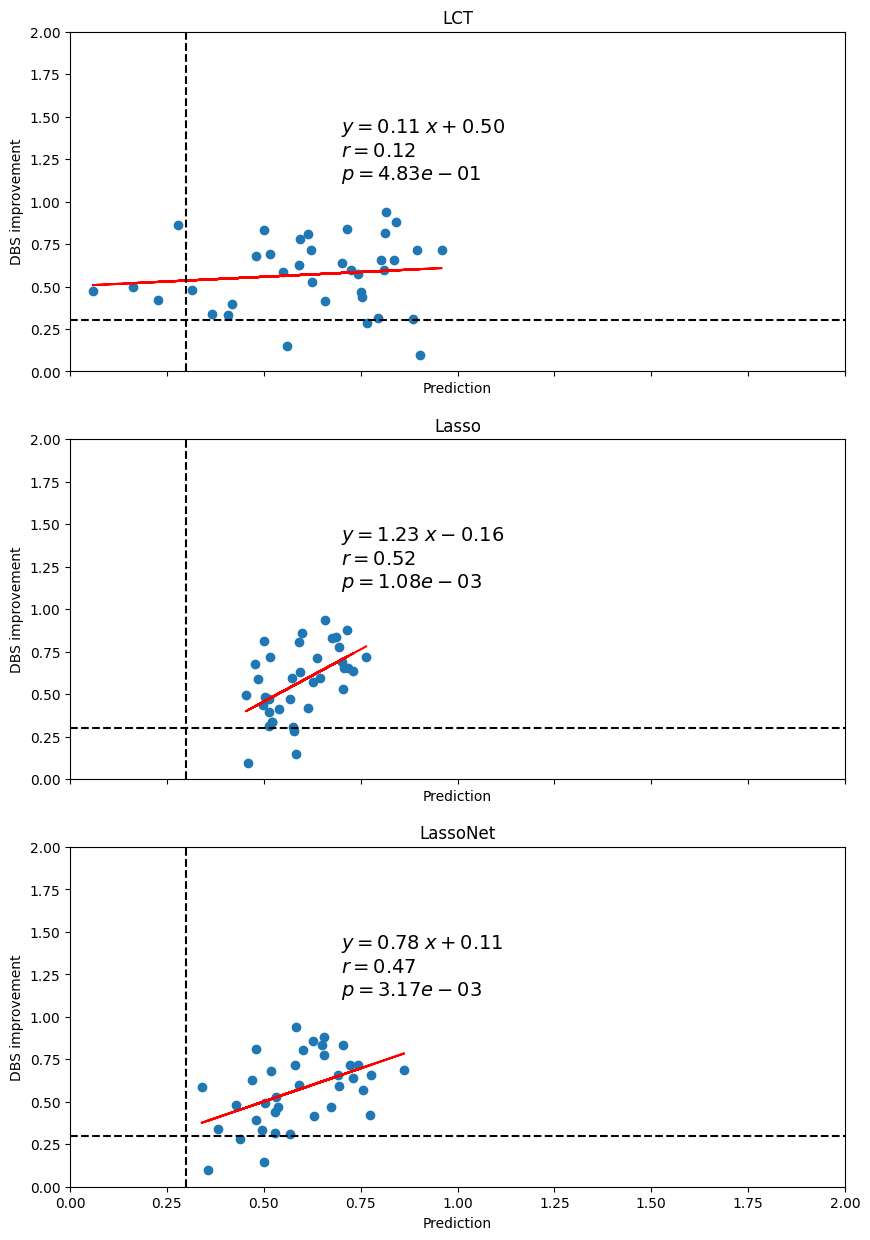

In [4]:
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               results_bls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                'LassoNet'
                                ],(30,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

